# Is the sunshine at a place affected by topography? 


In [4]:
import numpy as np
import pandas as pd

import proplot as plot

%load_ext autoreload 
%autoreload 2

from sunhours_calc import sunHours,azimuth_matrix_factory
import sunhours_plot as sunPlot

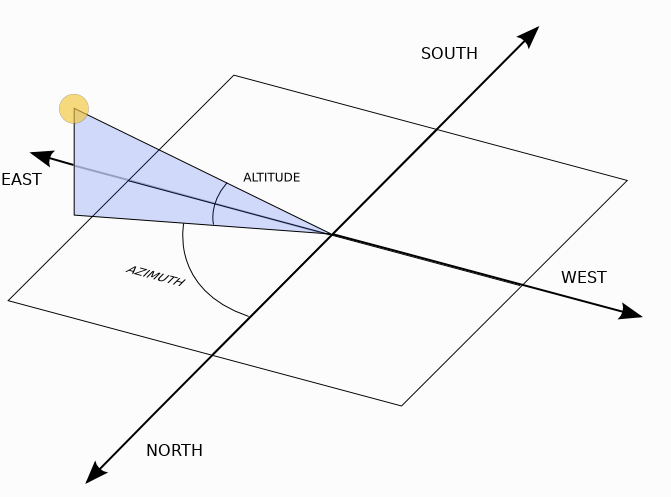


How many theoretical sun hours will a place get during a year? And how much of it is blocked by topography? We consider the high-resolution topography within 10 km from the place of interest, defined by latitude and longitude. We interpolate topography to go along a straight azimuth angle, and then use the topography to find the largest angle from the house. If the elevation angle of the sun is larger than the topography angle in the same azimuth angle, we consider the place to get sun. 


# How much sun does this house actually get? 

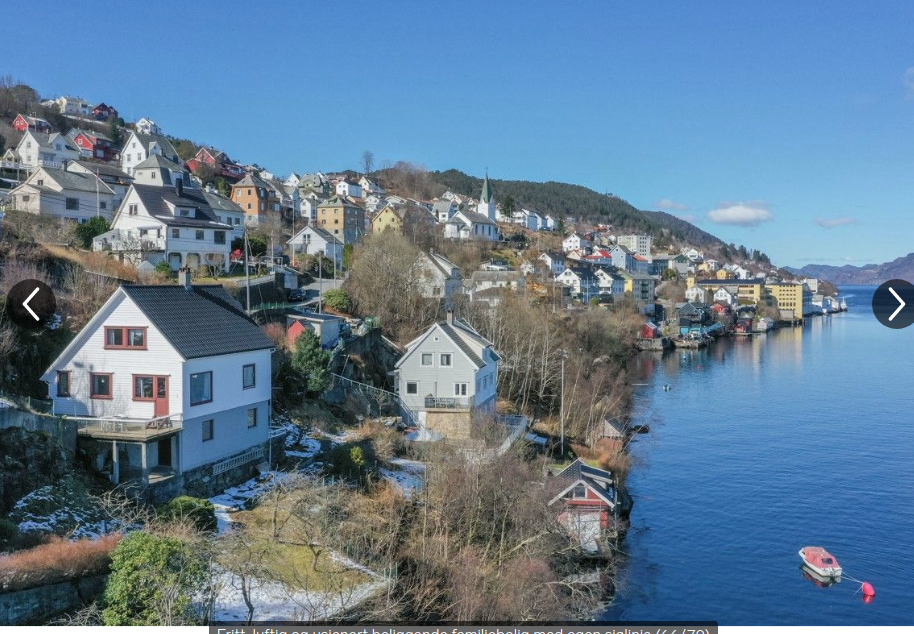



---
First, initial the location and the dates, in this case, we are interested in the sun conditions during the entire year

In [7]:
test_places = {'Arna'        : (60.456752213904245,5.443853229924588),
               #'Lerkerinden' : (60.34208077176912, 5.362093098116615),
               #'Hjemme'      : (60.378224338465834, 5.327000241043094),
             #  'GFI'         : (60.38376434332239, 5.331910883373496),
            #   'Askoy'       : (60.42224944507916, 5.233487259204554),
         #      'Dale'        : (60.59119166539618, 5.8217701204849535)
              }


dates=pd.date_range('01-01-2021','12-31-2021',freq='10T',tz='Europe/Oslo')

In [8]:
test_places.keys()

dict_keys(['Arna'])

In [9]:
testPlace_sun = {}
topo_Place =  {}
mtrx_Place  = {}
for place in test_places:
    print(place)
    lat, lon = test_places[place]
    topo_L,mtrx_L,sunny_df_L = sunHours(lon,lat,dates,buffer=10,reso='hi')
    
    testPlace_sun[place] = sunny_df_L
    mtrx_Place[place] = mtrx_L
    topo_Place[place] = topo_L

Arna
preparing azimuth matrix ...
finding sun hours ...


/opt/anaconda3/envs/Tills_normal/lib/python3.7/site-packages/pysolar/solartime.py:114: UserWarning: I don't know about leap seconds after 2020
  (leap_seconds_base_year + len(leap_seconds_adjustments) - 1)


finsihed


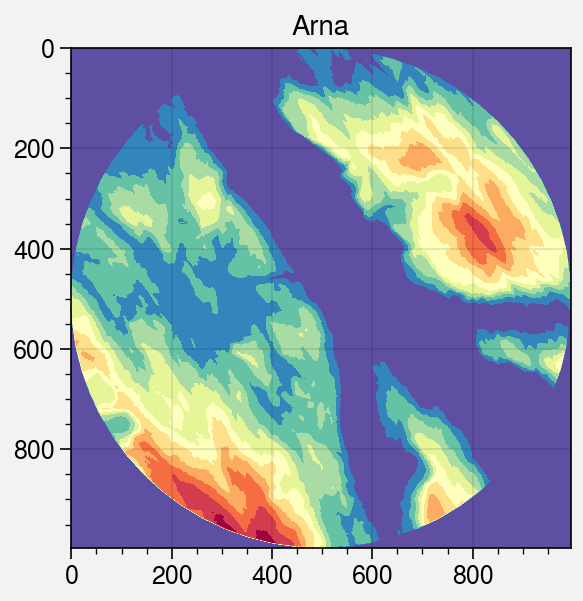

In [12]:
fig,axs = plot.subplots(ncols=len(topo_Place.keys()))
for ax,place in zip(axs,topo_Place):
    ax.imshow(topo_Place[place],cmap='spectral_r')
    ax.set_title(place)

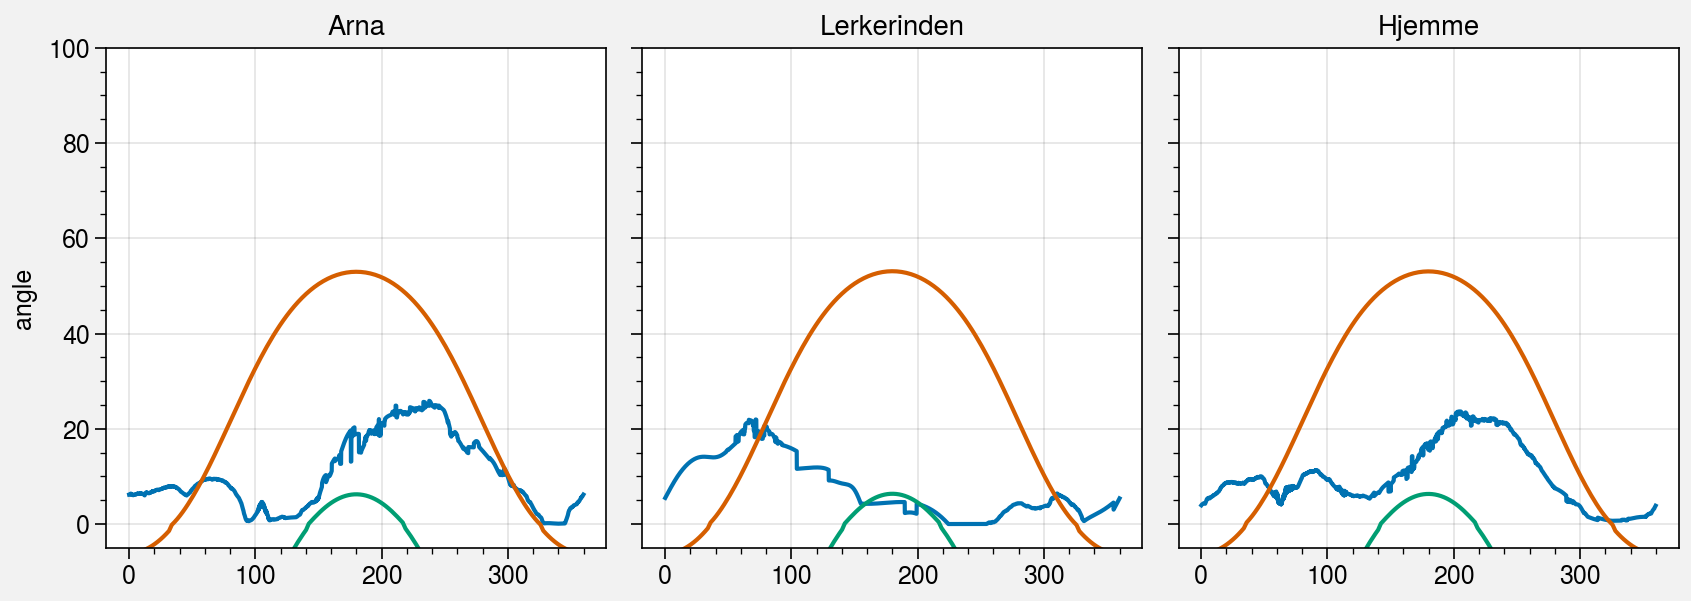

In [14]:
fig,axs = plot.subplots(ncols=len(topo_Place.keys()))
for ax,place in zip(axs,topo_Place):
    ax.plot(mtrx_Place[place].angle)
    sunny_df = testPlace_sun[place]
    summer_solstice = '2021-06-23'
    winter_solstice = '2021-12-22'
    ax.set_title(place)
    ax.plot(sunny_df.loc[summer_solstice].az.values,sunny_df.loc[summer_solstice].ze.values)
    ax.plot(sunny_df.loc[winter_solstice].az.values,sunny_df.loc[winter_solstice].ze.values)
    ax.format(ylim=[-5,100])

In [41]:
sunny_df.loc[date]

sun     angle         ze          az
2021-12-23 00:00:00+00:00  False  5.791137  -52.84652    8.547024
2021-12-23 00:10:00+00:00  False  6.443301 -52.622783   12.316255
2021-12-23 00:20:00+00:00  False  7.787968 -52.320059   16.047915
2021-12-23 00:30:00+00:00  False  8.661169  -51.94052   19.732111
2021-12-23 00:40:00+00:00  False  8.822304 -51.486794   23.360143
...                          ...       ...        ...         ...
2021-12-23 23:10:00+00:00  False  1.503895 -52.718184   349.35278
2021-12-23 23:20:00+00:00  False  1.906876 -52.906113  353.134464
2021-12-23 23:30:00+00:00  False  2.488257 -53.012876  356.937702
2021-12-23 23:40:00+00:00  False   4.17087 -53.037668    0.750653
2021-12-23 23:50:00+00:00  False  5.291236   -52.9803    4.561198

[144 rows x 4 columns]

In [44]:
def _prepareTime_(sun_daily):
    import datetime

    my_day = datetime.date(2021, 1, 1)
    
    x_dt = [datetime.datetime.combine(my_day, t) for t in sun_daily.index]
    y_dt = [datetime.datetime(2021, 1, 1) + datetime.timedelta(day - 1) for day in sun_daily.columns]
        
    return x_dt, y_dt


def _dataPrepare_(sunny_df):
    s_df= sunny_df.assign(doy = lambda x : x.index.day_of_year)
    sun_daily = pd.DataFrame(index=np.arange(1,366),columns=np.unique(s_df.index.time))
    ze_daily  = sun_daily.copy()
    
    for i in range(1,366): 
        if len( s_df.query('doy==@i'))==144:
            sun_daily.iloc[i-1] = s_df.query('doy==@i').sun
            ze_daily.iloc[i-1]  = s_df.query('doy==@i').ze

    sun_daily = sun_daily.astype(float).transpose()
    ze_daily  = ze_daily.astype(float).transpose()

    ze_bool = ze_daily>0
    
    return sun_daily, ze_bool

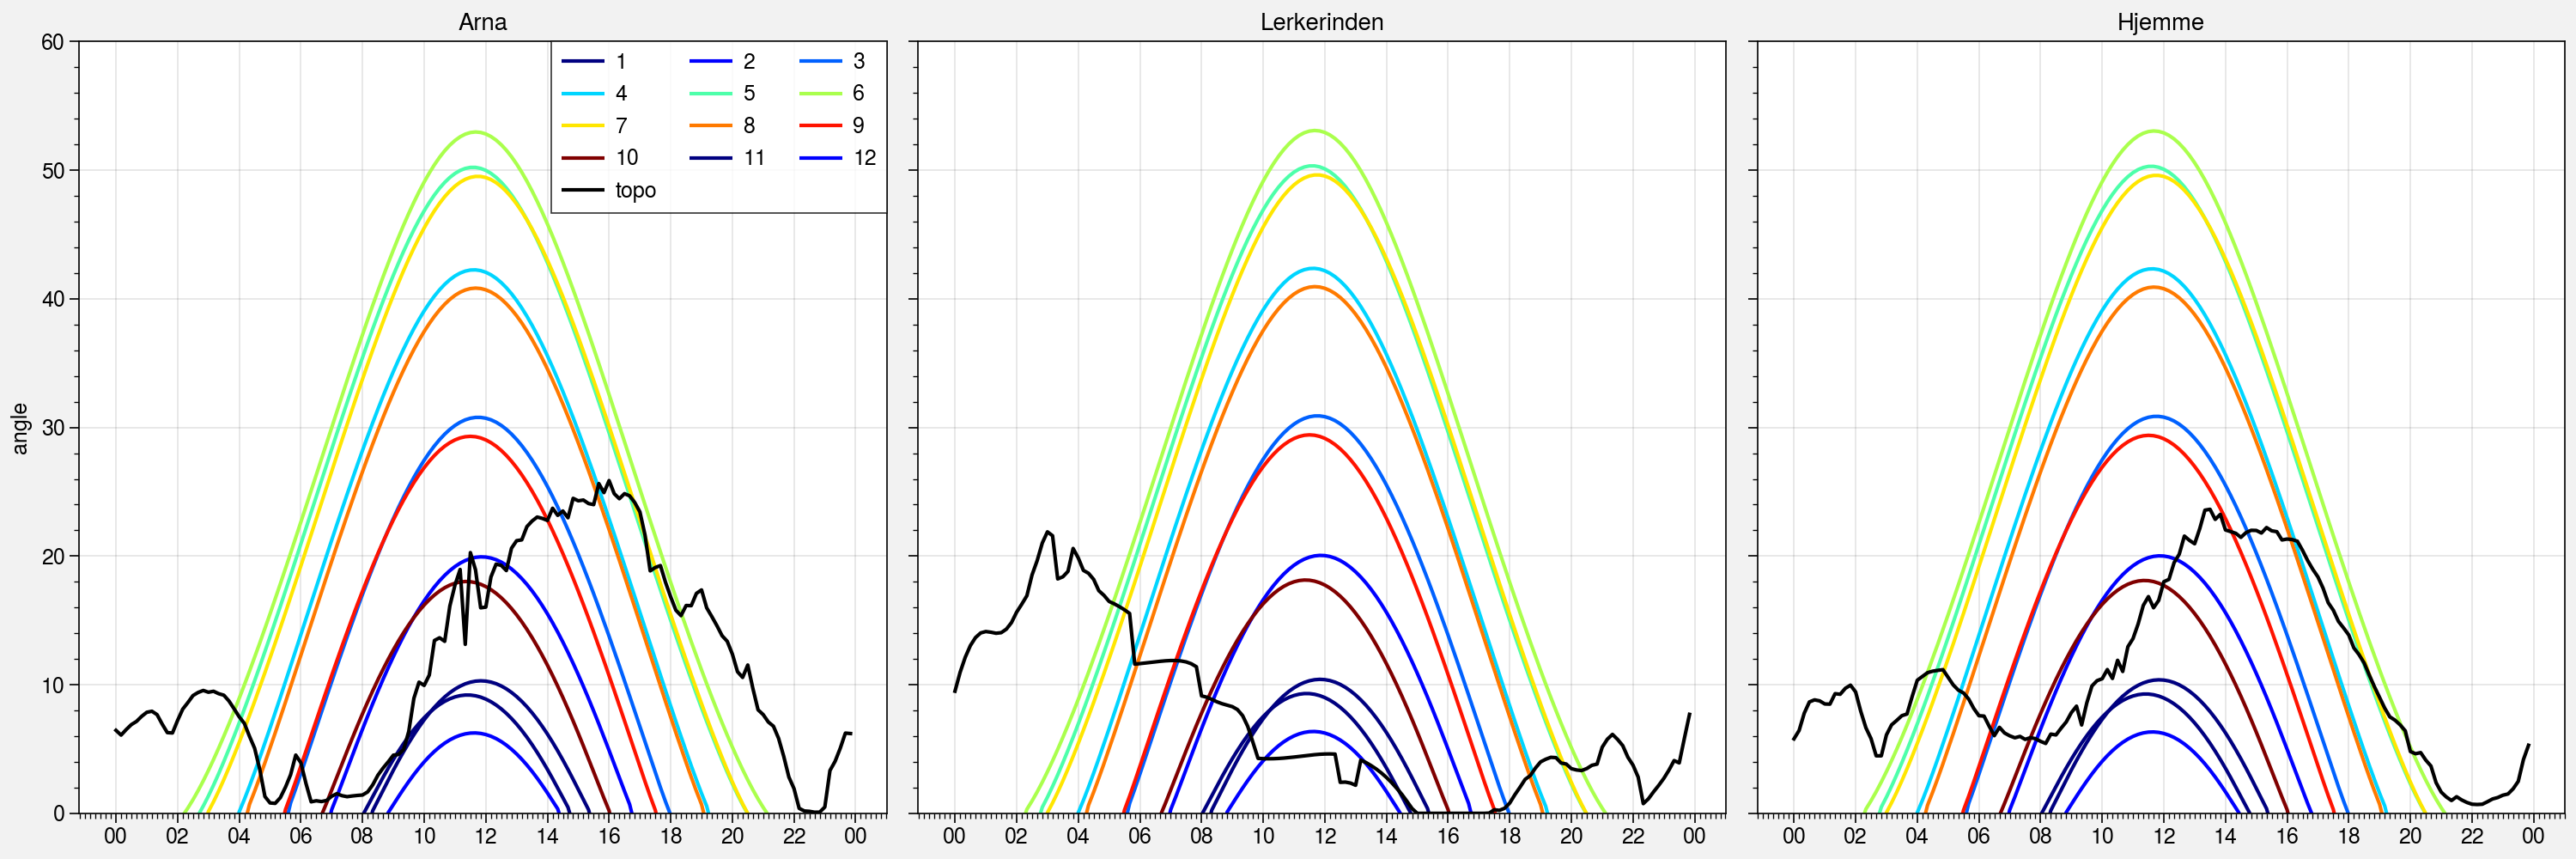

In [89]:
fig,axs = plot.subplots(ncols=len(topo_Place.keys()),figsize=(15,5),sharex=False)
a,b = _dataPrepare_(testPlace_sun['Arna'])
x_dt,y_dt = _prepareTime_(a)

for ax,place in zip(axs,topo_Place):
    #ax.plot(mtrx_Place[place].angle)
    sunny_df = testPlace_sun[place]
    ax.set_title(place)
    for month in np.arange(1,13):
        date ='2021-'+str(month)+'-23'
        ax.plot(x_dt,sunny_df.loc[date].ze.values,label=month,cycle='Jet')
    ax.plot(x_dt,sunny_df.loc[date].angle,color='k',label='topo')
axs.format(xrotation=0,xlocator=('hour', range(0, 24, 2)),
      xminorlocator=('minute', range(0, 60, 10)), 
      xformatter='%H',
      ylim=[0,60]
         )
axs[0].legend()

/home/kko033/anaconda3/envs/extreme_precip/lib/python3.7/site-packages/proplot/axes/plot.py:507: MatplotlibDeprecationWarning: 
The IndexFormatter class was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  kw[xname + 'formatter'] = mticker.IndexFormatter(x)


<BarContainer object of 3 artists>

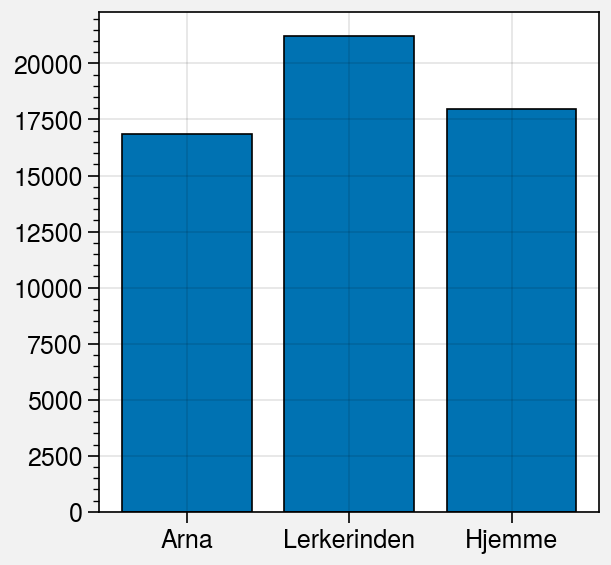

In [86]:
# Sun hours during the year

sunHours = pd.DataFrame([testPlace_sun[place].sun.sum() for place in testPlace_sun],index=testPlace_sun.keys())

fig,ax = plot.subplots()
ax.bar(sunHours)

---

In [ ]:
lat,lon = test_places['Arna']

topo_L,mtrx_L,sunny_df_L = sunHours(lon,lat,dates,buffer=10,reso='hi')


fig,ax = plot.subplots(ncols=2,sharey=False)
plot.rc['font.size']=20
ax[0].imshow(topo_L,colorbar='r',levels=np.arange(0,600,1))
ax[1].plot(mtrx_L.angle)


sunny_df_L

f,a   = sunPlot.plotActualAgainstTheory(sunny_df_L)

f,a = sunPlot.plotSolarElevation(sunny_df_L,mtrx_L)